# Predict Distributions - TopDown

Predict timing and size of distributions of ETFs

Apply a TopDown approach with using time-series models on fund level



In [1]:
# General
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import re

# File download
from tqdm.notebook import tqdm, trange

# Custom modules
from Tools import S3

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt

# Hidden configurations
from mySecrets import config_file, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_BUCKET


In [2]:
# Connect to AWS S3 storage
s3 = S3()
s3.connect(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

Connected.


In [3]:
# Download all distribution data
date = "2022_03_24"

# Get list of avilable files -> do not know yet, if all uploads were successful
file_list = s3.listFiles(AWS_BUCKET, "data/distribution_clean/" + date)

# Extract ISIN from filename
df_file = pd.DataFrame(file_list, columns = ['file'])
df_file['ISIN'] = df_file['file'].str.extract(r"([A-Z0-9]{12})", expand = False).fillna('no match')

df_dist = pd.DataFrame(columns = ['Security_ISIN'])

for i, record in tqdm(df_file[0:].iterrows(), total = df_file[0:].shape[0]):

    key = record['file']
    isin = record['ISIN']

    filename = './temp/' + isin + ".tsv"

    s3.downloadFile(AWS_BUCKET, key, filename)

    # Read tsv file
    df_temp = pd.read_csv(filename, sep = "\t")

    # Rename columns
    df_temp = df_temp.rename(columns={
        'ExTag': 'Dist_Date_Ex',
        'Fälligkeitsdatum': 'Dist_Date_Payment',
        'Stichtag': 'Dist_Date_Record',
        'ISIN': 'Security_ISIN',
        'Dist': 'Dist_Amount'
    })

    df_dist = df_dist.append(df_temp)

  0%|          | 0/141 [00:00<?, ?it/s]

In [4]:
# Adjust order of columns
df_dist = df_dist[['Security_ISIN', 'Dist_Amount', 'Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment']]
df_dist.head()

,Security_ISIN,Dist_Amount,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment
0,IE0005042456,0.0427,2022-03-17,2022-03-18,2022-03-30
1,IE0005042456,0.0480,2021-12-16,2021-12-17,2021-12-31
2,IE0005042456,0.0855,2021-09-16,2021-09-17,2021-09-29
3,IE0005042456,0.0813,2021-06-17,2021-06-18,2021-06-30
4,IE0005042456,0.0562,2021-03-11,2021-03-12,2021-03-24


In [5]:
# Format dates
# Ex < Record < Payment

# # Select all observations, where all 3 dates are available
df_dist_dates = df_dist.dropna(subset=['Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment'], how='any').copy()

# # Transform all date columns to datetime
# from datetime import datetime
# import locale

# # Datetime doesnot recognie "Mär"|"Mar" with german locale de_DE
# locale.setlocale(locale.LC_ALL, 'en_US')

# d = {'Mär':'Mar', 'Mai':'May','Okt':'Oct','Dez':'Dec'}

df_dist_dates['Dist_Date_Ex'] = pd.to_datetime(df_dist_dates['Dist_Date_Ex'], format="%Y-%m-%d")
df_dist_dates['Dist_Date_Record'] = pd.to_datetime(df_dist_dates['Dist_Date_Record'], format="%Y-%m-%d")
df_dist_dates['Dist_Date_Payment'] = pd.to_datetime(df_dist_dates['Dist_Date_Payment'], format="%Y-%m-%d")

df_dist_dates.head()




,Security_ISIN,Dist_Amount,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment
0,IE0005042456,0.0427,2022-03-17,2022-03-18,2022-03-30
1,IE0005042456,0.0480,2021-12-16,2021-12-17,2021-12-31
2,IE0005042456,0.0855,2021-09-16,2021-09-17,2021-09-29
3,IE0005042456,0.0813,2021-06-17,2021-06-18,2021-06-30
4,IE0005042456,0.0562,2021-03-11,2021-03-12,2021-03-24


## Map daily data to quarters

The forecast model will operate on quarterly data. For this, the available daily data needs to be mapped onto quarters.

For this, we assign custom quarters which take into account the nature of accounting. And will rather be data-driven than follow the usual defintion of quarters.

Meaning, there will be 1,2 or 4 distributions in a year from each fund. The actual timing of the distributions must not coincide with the usual definition of quarters.
For example, a fund with 4 distributions in year, could have the second distribution always around the end of march. When, for whateve reason, the distribution is delayed by some days to the 2nd of April for example, this distribution could be assigned to the second quarter. Now, our model would think that there would be only 3 quarters with distributions in that year.
Even though, there are 4, and the difference in days between the second and third distributions only changed by a few days.

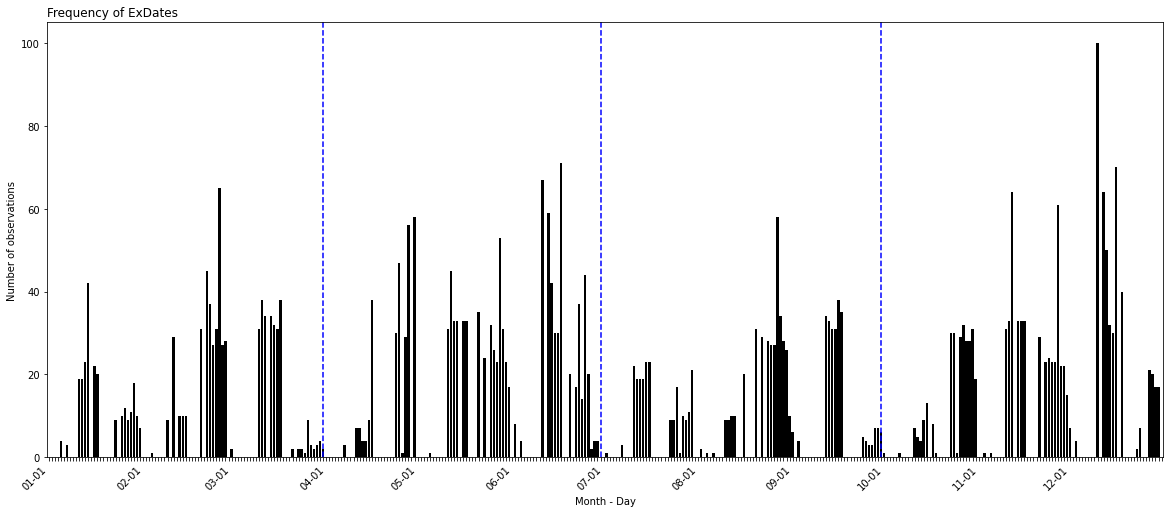

In [6]:
# Inspect the distribution of observations - Ex Date

df_plot = df_dist_dates[['Security_ISIN', 'Dist_Date_Ex']].rename(columns={'Dist_Date_Ex':'Date'}).copy()

# Extract month_day from date and add dummy year
df_plot['Date'] = [str(d) + "_" + str(m) + "_2000" for m,d in zip(df_plot.Date.dt.month, df_plot.Date.dt.day)]

# Transform to datetime
df_plot['Date'] = pd.to_datetime(df_plot['Date'], format="%d_%m_%Y")

# Aggregate by date
df_plot = df_plot.groupby('Date').size().reset_index(name='obs')

# Add possibly missing dates
idx = pd.date_range('2000-01-01', '2000-12-31')
df_plot = pd.DataFrame(data={'Date': idx}).join(df_plot.set_index('Date'), on = 'Date')

# Replace NA
df_plot = df_plot.fillna(0)

dates = list(df_plot.Date.dt.strftime('%m-%d'))

# # # Draw the graph
fig = plt.figure(figsize=(20, 8))

# # # # Cannot use histplot; need column plot
ax = sns.barplot(data=df_plot, x='Date', y='obs', color='black')

# Custom x labels -> display first day of the month?
x_lab = [d.strftime('%m-%d') if d.day == 1 else "" for d in df_plot.Date]
ax.set_xticklabels(labels=x_lab, rotation=45, ha='right')

# Add vertical lines for actual end of quarters
plt.axvline(x = dates.index('03-31'), color='blue', ls='--')
plt.axvline(x = dates.index('06-30'), color='blue', ls='--')
plt.axvline(x = dates.index('09-30'), color='blue', ls='--')

# Add vertical lines for newly assigned end of quarters
# TODO: Do not need to reassign quarters!

plt.title("Frequency of ExDates", loc='left')

plt.xlabel('Month - Day')
plt.ylabel('Number of observations')

plt.show()


In [7]:
# Aggregate daily data to quarters
df_temp = df_dist_dates[['Security_ISIN', 'Dist_Date_Ex', 'Dist_Amount']].rename(columns={'Dist_Date_Ex':'Date'}).copy()

df_temp['Year'] = df_temp.Date.dt.year

def transDateToQuarter(month, day):

    # Define cut off date, i.e. how many days after a quarter are still assigned to the last quarter
    cut = 0

    if ((month == 1) & (day > cut)) | (month == 2) | (month == 3) | ((month == 4) & (day <= cut)):
        return(1)
    elif ((month == 4) & (day > cut)) | (month == 5) | (month == 6) | ((month == 7) & (day <= cut)):
        return(2)
    elif ((month == 7) & (day > cut)) | (month == 8) | (month == 9) | ((month == 10) & (day <= cut)):
        return(3)
    else:
        return(4)

df_temp["Q"] = [transDateToQuarter(m, d) for m, d in zip(df_temp.Date.dt.month, df_temp.Date.dt.day)]

# Create year-q combi
df_temp["Y_Q"] = [str(i) + "Q" + str(j) for i,j in zip(df_temp['Year'], df_temp['Q'])]

# Format as datetime(year, quarter)
# pd.to_datetime(df_temp.Y_Q, format = "%YQ%q")
df_temp["Y_Q"] = pd.PeriodIndex(df_temp.Y_Q, freq = 'Q')


# # # Change typ of dist column to numeric
df_temp[df_temp.Dist_Amount == "--"] = "0"
df_temp['Dist_Amount'] = df_temp.Dist_Amount.astype(float)

# # # Group by new column
df_temp = df_temp.groupby(['Security_ISIN', 'Y_Q', 'Year']).agg({'Dist_Amount': 'sum'}).reset_index()

df_temp = df_temp[~(df_temp.Security_ISIN == "0")]

df_temp["Y_Q"] = pd.PeriodIndex(df_temp.Y_Q, freq='Q').to_timestamp()

df_temp.head()


,Security_ISIN,Y_Q,Year,Dist_Amount
0,IE0005042456,2000-07-01,2000,0.0637
1,IE0005042456,2000-10-01,2000,0.0229
2,IE0005042456,2001-01-01,2001,0.0188
3,IE0005042456,2001-04-01,2001,0.1014
4,IE0005042456,2001-07-01,2001,0.0443


In [8]:
# Extend DF by missing quarters. 
# ETF-products that distribute only every second quarter, will not have an observation for every other quarter. 
# Need to fill that with 0s.

# Calculate min and max dates per isin
df_expand = df_temp.groupby(['Security_ISIN']).agg({'Y_Q':['min', 'max']}).reset_index()

# expand dates
df_check_ = pd.DataFrame()

for i, row in df_expand.iterrows():
    # Shift by one day, as this function returns last day in quarter, and function further up returned first day in new quarter
    i_range = pd.date_range(row[('Y_Q', 'min')], row[('Y_Q', 'max')], freq='Q') + timedelta(days=1)
    isin_i = row['Security_ISIN']
    df_range = pd.DataFrame(data={'Y_Q': i_range})
    df_range['Security_ISIN'] = isin_i[0]
    df_check_ = df_check_.append(df_range)

df_temp_exp = (
    df_check_.
    join(df_temp.set_index(['Security_ISIN', 'Y_Q']), on = ['Security_ISIN', 'Y_Q'])
) 

# Fill NA values
df_temp_exp['Year'] = df_temp_exp.Y_Q.dt.year
df_temp_exp = df_temp_exp.fillna(value={'Dist_Amount':0})
df_temp_exp.describe()


,Year,Dist_Amount
count,5444.000000,5444.000000
mean,2014.985672,0.332727
std,4.654021,0.669851
min,2000.000000,0.000000
25%,2011.000000,0.000000
50%,2016.000000,0.082000
75%,2019.000000,0.319850
max,2022.000000,9.740900


In [9]:

# df_temp_exp[df_temp_exp.Security_ISIN == 'IE00B296QM64']

## Inspect distribution patterns

Inspect different type of distribution behaviors

* Do we have upward / downward trends?
* Are there outliers; maybe due to high one-time payments
* Is there erratic behavior? Is the distribution even predictable with a top-down approach?

And how does this look like on a quarterly vs yearly perspective? As is and for moving average/sum?

Can we predict on ??? :
* Quarterly
* Yearly
* Moving averages/sum

How to evaluate a good model? RMSE? MAPE?

<Figure size 1440x576 with 0 Axes>

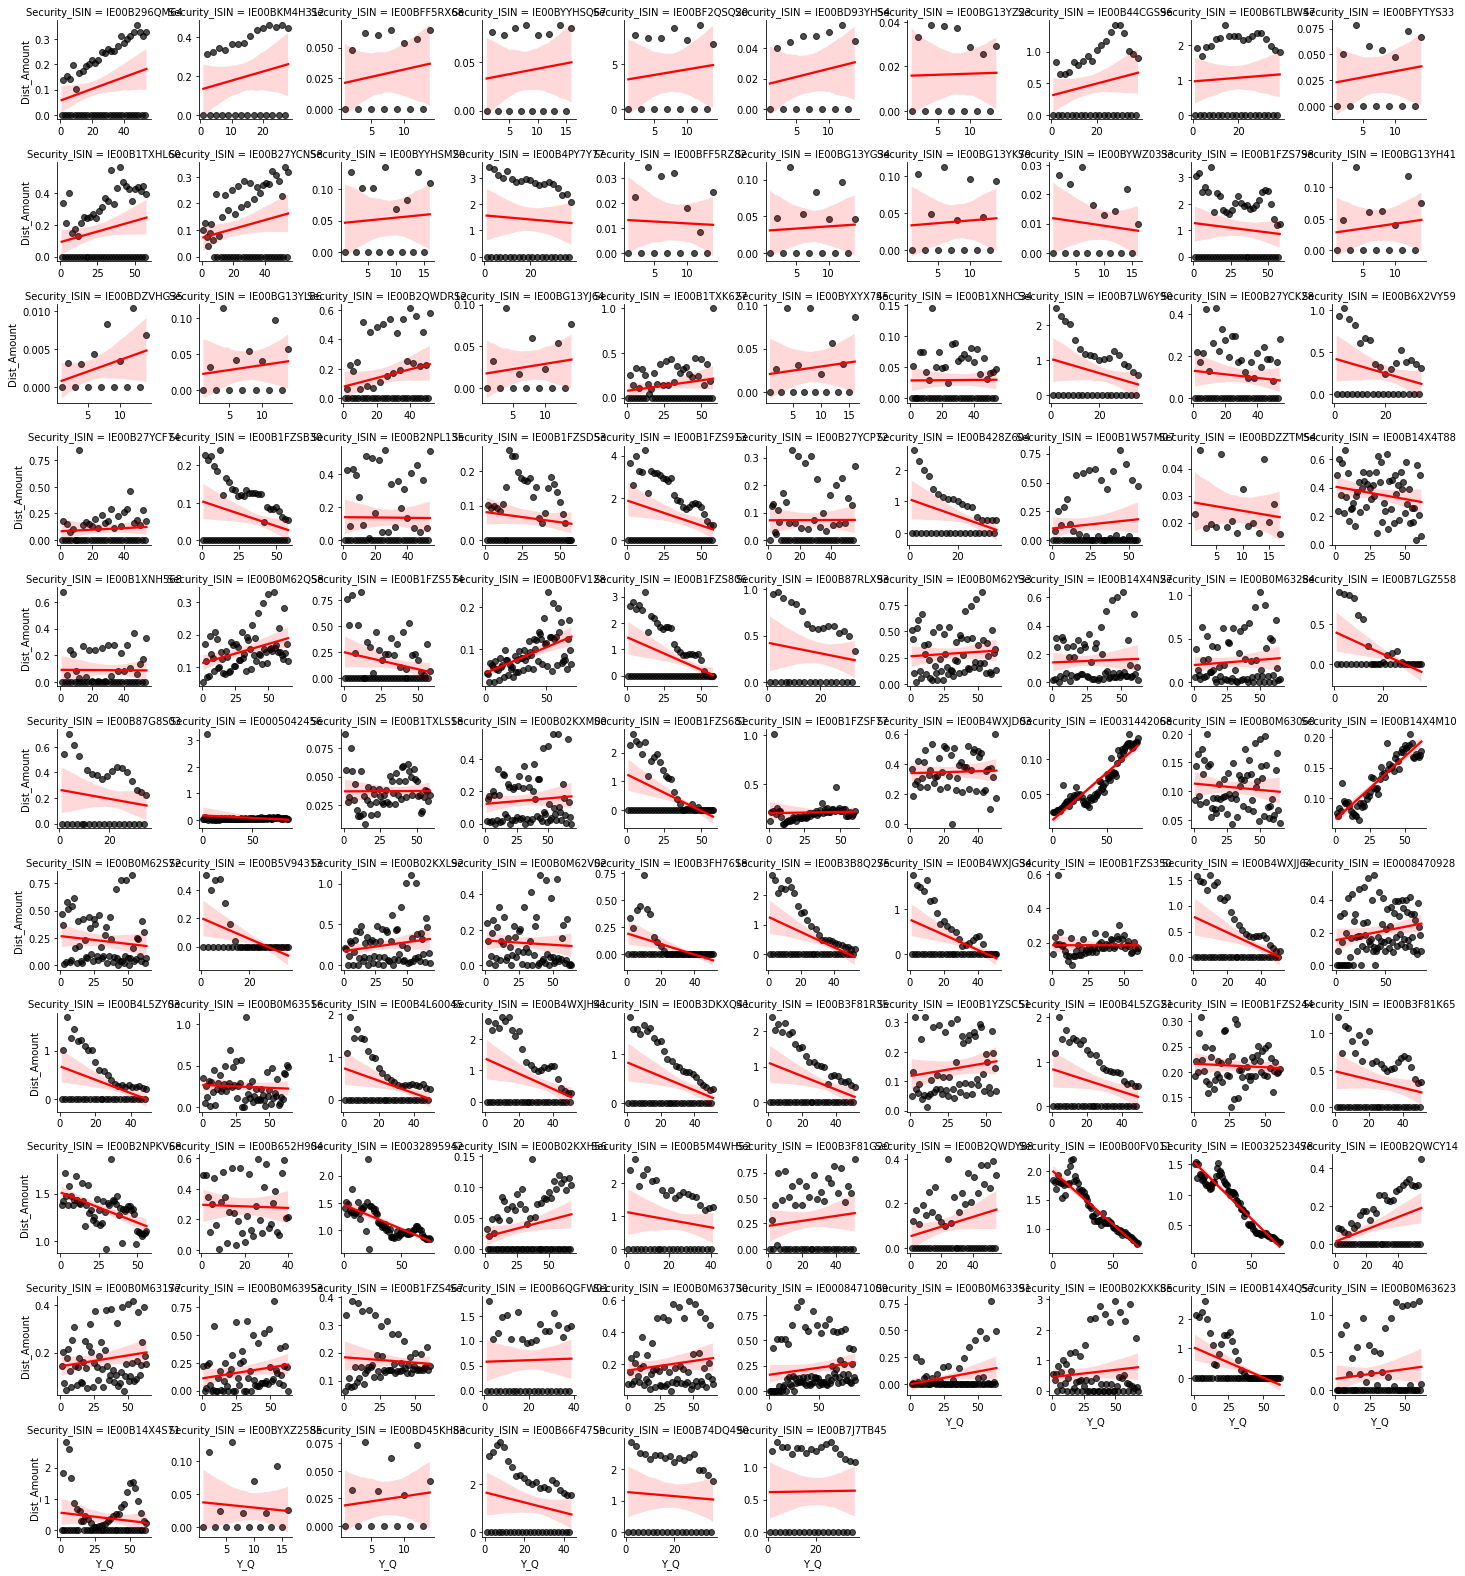

In [10]:
# Find and define different patterns

# Arrange scatter plots by correlation to selected ETF product

import scipy.stats

# Seasonality and somewhat downward trend
# sns.lineplot(data = df_temp[df_temp.Security_ISIN == 'IE0008471009'], x = "Y_Q", y = 'Dist_Amount')

# Discontinue of distributions -> paid for several years and then stopped
# No trend at all -> random cloud of data points
# ---> ???


# replace timestampe Y_Q with counter so that poly_fit can work
df_plot = df_temp_exp.copy()
df_plot['Y_Q'] = df_plot.groupby('Security_ISIN').cumcount() + 1

# Filter to securities with at least 3 years of data, i.e. Y_Q > 12
df_plot_filter = df_plot.groupby('Security_ISIN')['Y_Q'].max().reset_index()
df_plot_filter = df_plot_filter[df_plot_filter.Y_Q > 12]
df_plot = df_plot[df_plot.Security_ISIN.isin(df_plot_filter.Security_ISIN)]


# Sort ISINS by highest correlation to benchmark isin
isin_bench = "IE00B296QM64"
isin_list = df_temp.Security_ISIN.unique()
isin_dict = {}

df_bench = df_temp_exp[df_temp_exp.Security_ISIN == isin_bench][['Y_Q', 'Dist_Amount']].rename(columns = {'Dist_Amount': 'Dist_Bench'})


for isin_i in isin_list:

    try:
        df_i = df_temp_exp[df_temp_exp.Security_ISIN == isin_i][['Y_Q', 'Dist_Amount']]

        df_i = df_bench.join(df_i.set_index(['Y_Q']), on = 'Y_Q', how = 'inner')

        isin_dict[isin_i] = [scipy.stats.pearsonr(df_i.Dist_Bench, df_i.Dist_Amount)[0]]
    except:
        print(isin_i)

df_sort = pd.DataFrame.from_dict(isin_dict)
df_sort = pd.DataFrame(df_sort.loc[0,])
df_sort.reset_index(inplace = True)
df_sort.columns = ['Security_ISIN', 'Cor']
df_plot = df_plot.join(df_sort.set_index('Security_ISIN'), on = 'Security_ISIN', how = 'left').sort_values(['Cor', 'Y_Q'], ascending = [False, True])


# # # Draw the graph
fig = plt.figure(figsize=(20, 8))

g = sns.FacetGrid(df_plot, col="Security_ISIN", col_wrap=10, height=2, sharey=False, sharex=False)
g.map(sns.regplot, "Y_Q", "Dist_Amount", order=1, scatter_kws={"color": "black", "alpha": 0.7}, color = "red")


<Figure size 1440x576 with 0 Axes>

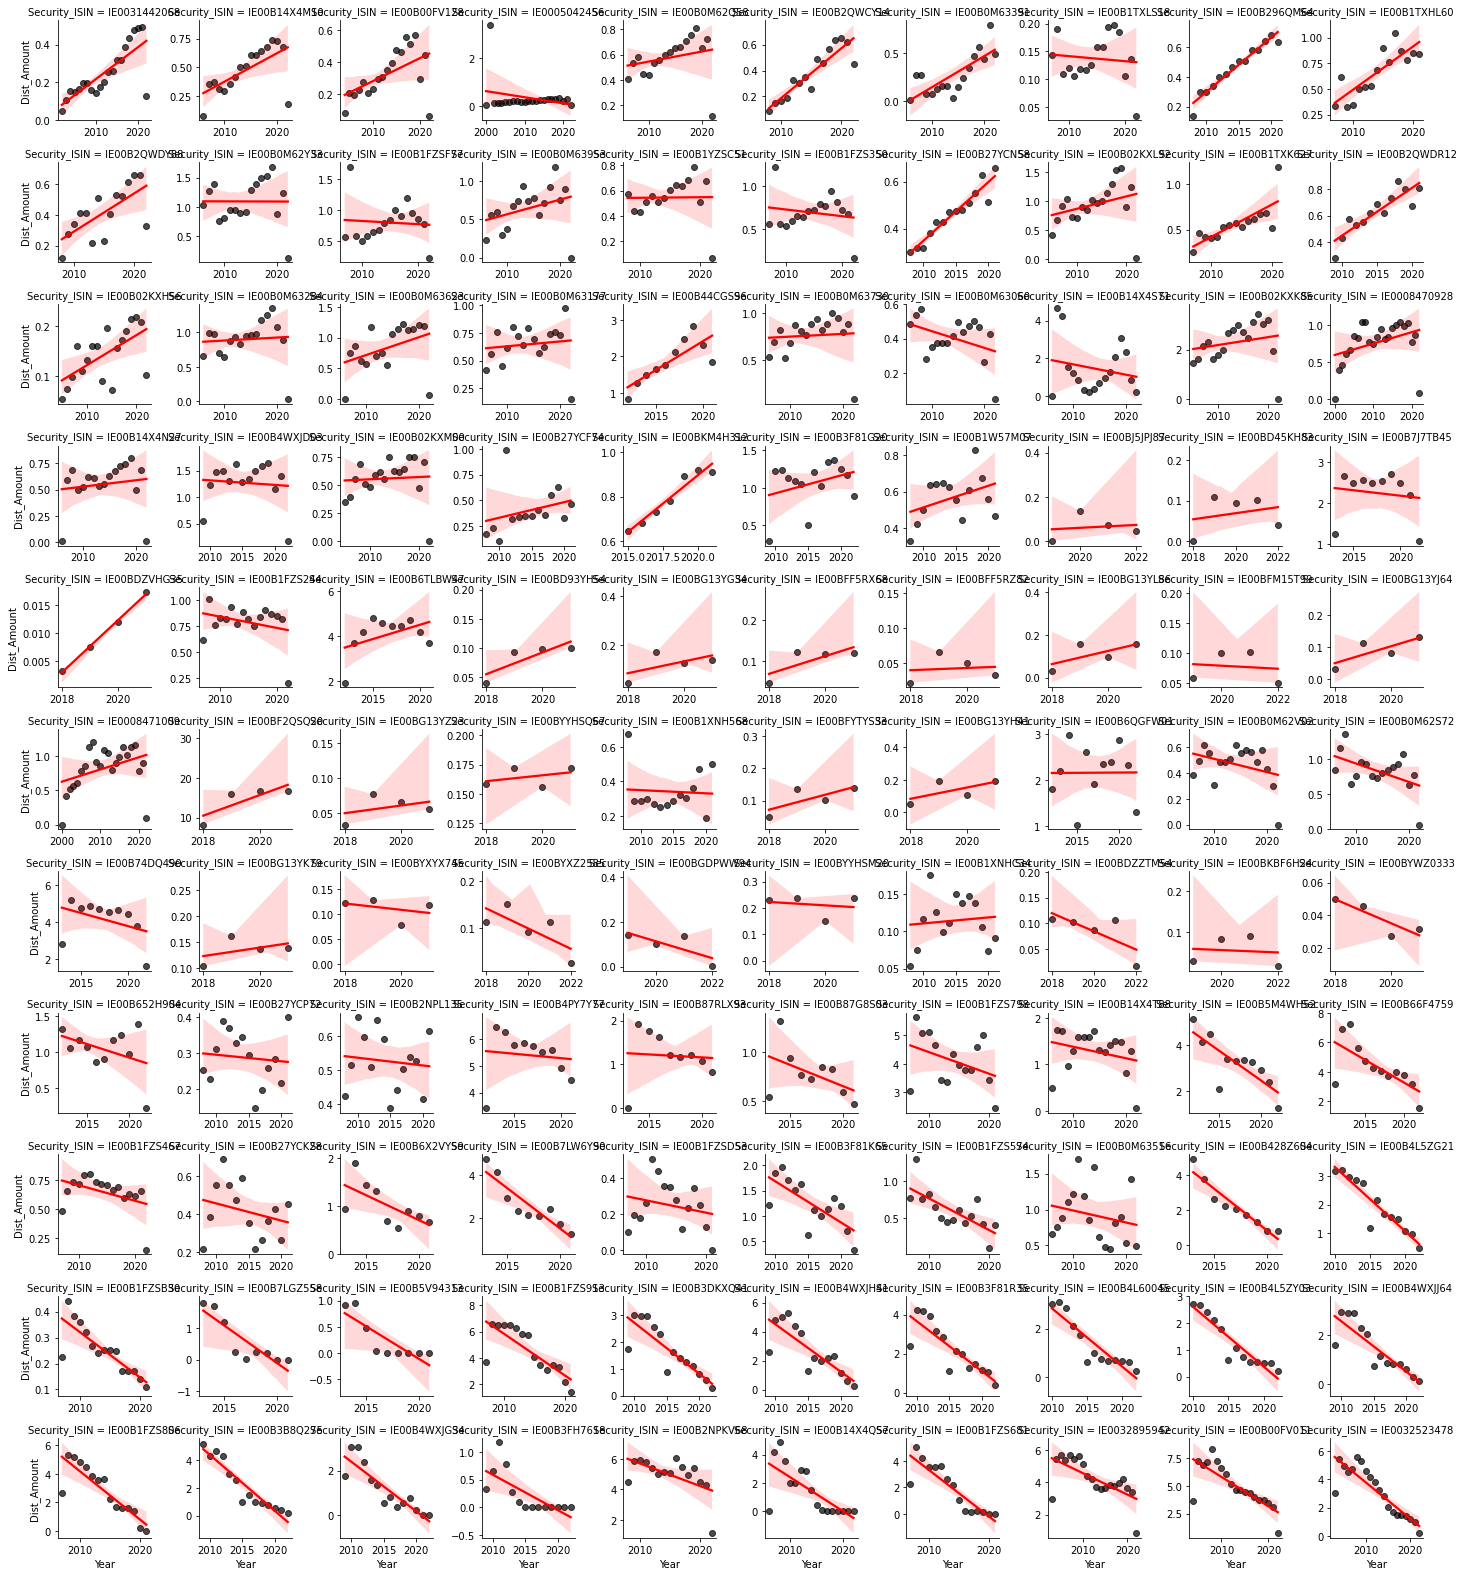

In [28]:
# There are many products which do not distribute every quarter.
# Inspect yearly data

import scipy.stats

# replace timestampe Y_Q with counter so that poly_fit can work
df_plot = df_temp_exp.copy()
df_plot = df_plot.groupby(['Security_ISIN', 'Year']).agg({'Dist_Amount':'sum'}).reset_index()
# df_plot['Y_Q'] = df_plot.groupby('Security_ISIN').cumcount() + 1

# # Filter to securities with at least 3 years of data, i.e. Y_Q > 12
df_plot_filter = df_plot.groupby('Security_ISIN')['Year'].count().reset_index()
df_plot_filter = df_plot_filter[df_plot_filter.Year > 3]
df_plot = df_plot[df_plot.Security_ISIN.isin(df_plot_filter.Security_ISIN)]


# # Sort ISINS by highest correlation to benchmark isin
isin_bench = "IE00B296QM64"
isin_list = df_temp.Security_ISIN.unique()
isin_dict = {}

df_bench = df_temp_exp[df_temp_exp.Security_ISIN == isin_bench][['Year', 'Dist_Amount']].rename(columns = {'Dist_Amount': 'Dist_Bench'})


for isin_i in isin_list:

    try:
        df_i = df_temp_exp[df_temp_exp.Security_ISIN == isin_i][['Year', 'Dist_Amount']]

        df_i = df_bench.join(df_i.set_index(['Year']), on = 'Year', how = 'inner')

        isin_dict[isin_i] = [scipy.stats.pearsonr(df_i.Dist_Bench, df_i.Dist_Amount)[0]]
    except:
        print(isin_i)

df_sort = pd.DataFrame.from_dict(isin_dict)
df_sort = pd.DataFrame(df_sort.loc[0,])
df_sort.reset_index(inplace = True)
df_sort.columns = ['Security_ISIN', 'Cor']
df_plot = df_plot.join(df_sort.set_index('Security_ISIN'), on = 'Security_ISIN', how = 'left').sort_values(['Cor', 'Year'], ascending = [False, True])


# # # Draw the graph
fig = plt.figure(figsize=(20, 8))

g = sns.FacetGrid(df_plot, col="Security_ISIN", col_wrap=10, height=2, sharey=False, sharex=False)
g.map(sns.regplot, "Year", "Dist_Amount", order=1, scatter_kws={"color": "black", "alpha": 0.7}, color = "red")


Prediction on yearly data should be much easier than on quarterly data.

There seem to be some clear upward and downward trends. And not too many zeros.

## Inspect time series properties

Check Partial Autocorrelation, etc.

Check stationarity

Need these checks to determine which models might be appropriate and which features need to go into the model

Work on yearly data!

In [29]:
df_temp_exp_y = df_temp_exp.groupby(['Security_ISIN', 'Year']).agg({'Dist_Amount':'sum'}).reset_index()

### Augmented-Dickey-Fuller Test

In [30]:
from statsmodels.tsa.stattools import adfuller

def calc_adfuller(x_):

    x_d = np.diff(x_)

    # Check time series as is
    level_c = adfuller(x_)[1]

    # Check with trend
    level_ct = adfuller(x_, regression="ct")[1]

    # Check first differences
    diff_c = adfuller(x_d)[1]

    # Check first differences with trend
    diff_ct = adfuller(x_d, regression="ct")[1]

    return [level_c, level_ct, diff_c, diff_ct]

# Collect all results
dict_adfuller = {}

for isin_i in df_temp_exp_y.Security_ISIN.unique():

    x_ = df_temp_exp_y[df_temp_exp_y.Security_ISIN == isin_i]['Dist_Amount']

    if (len(x_)) > 8:

        dict_adfuller[isin_i] = calc_adfuller(x_)



df_adfuller = pd.DataFrame.from_dict(dict_adfuller, orient="index", columns=['level_c', 'level_ct', 'diff_c', 'diff_ct'])


<Figure size 1440x576 with 0 Axes>

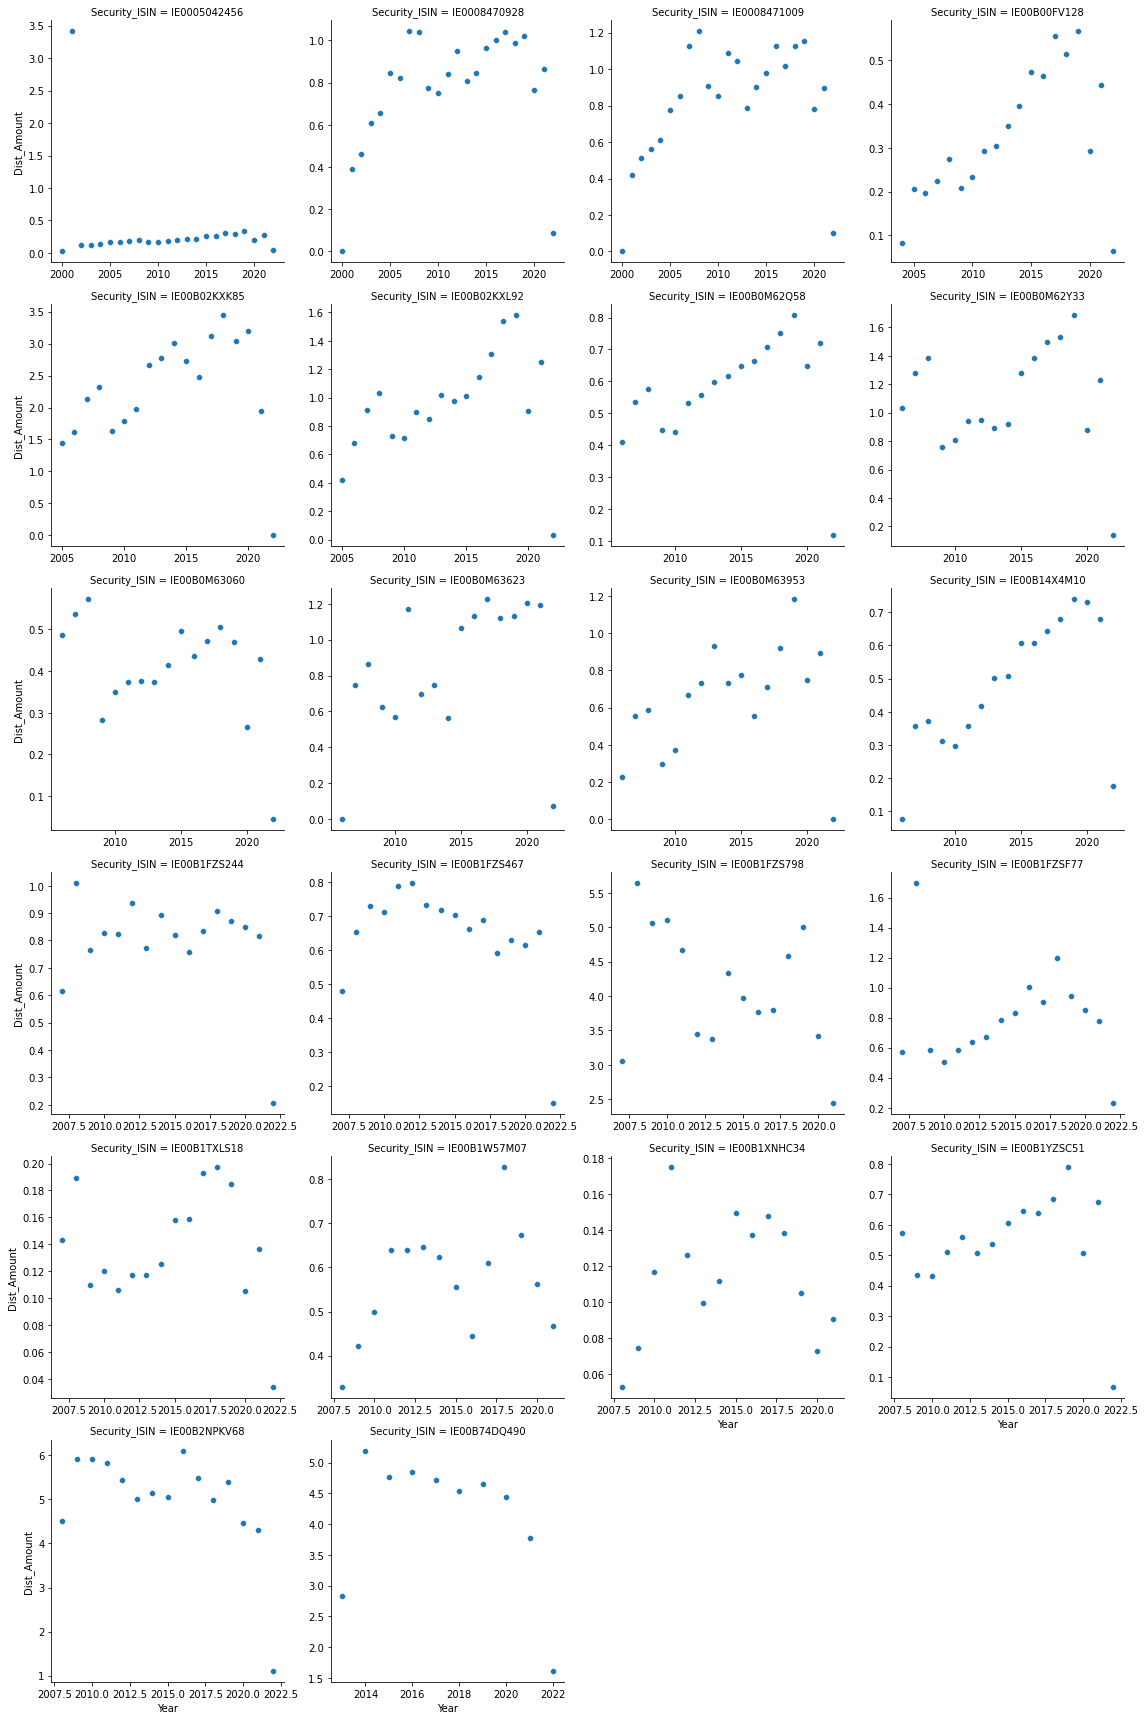

In [33]:
# Find problematic observations, i.e. where none of the adfuller tests rejects the H0

df_adfuller_problems = df_adfuller[(df_adfuller.level_c > 0.05) & (df_adfuller.level_ct > 0.05) & (df_adfuller.diff_c > 0.05) & (df_adfuller.diff_ct > 0.05)]

df_adfuller_plot = df_temp_exp_y.copy()

df_adfuller_plot = df_adfuller_plot[df_adfuller_plot.Security_ISIN.isin(df_adfuller_problems.index)]

fig = plt.figure(figsize=(20, 8))

g = sns.FacetGrid(df_adfuller_plot, col="Security_ISIN", col_wrap=4, height=4, sharey=False, sharex=False)
g.map(sns.scatterplot, "Year", "Dist_Amount")

# It looks like changes in the distribution policy. Seasonal distrbutions in the beginning, and then more evenly distributed over quarters
# And also not linear trends. Trend follows some poly-fit.

# But, luckily, only 2 observations seem problematic! And, from the visuals, those should be well approximated by linear trends.

Problems arise with outliers.

For once, those could be one-time payments.

Otherwise, extreme-events like Covid19 and the introduced ban on dividend payments on certain industries, destroy normal patterns.

### (Partial) Autocorrelation

Check how many lags could be relevant for our time series

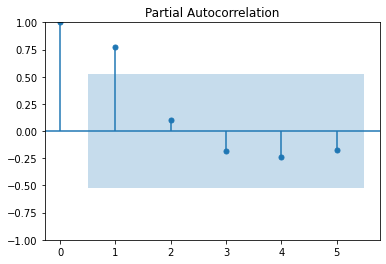

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

isin_i = "IE00B296QM64"

x_ = df_temp_exp_y[df_temp_exp_y.Security_ISIN == isin_i]['Dist_Amount']

plot_pacf(x_, lags=5, alpha=0.05)
plt.show()


# Calculate max lags for all ETF products
def calc_max_lag(x_):
    # Calculate partial autocorrelation function
    pacf_ = pacf(x_, nlags=5, alpha=0.05)

    # Collect results
    pacf_ = np.insert(pacf_[1], 0, np.transpose(pacf_[0]), axis=1)

    # Check which values with the same calculations performed in plot_pacf
    pacf_check = (pacf_[:,0] > (pacf_[:,0] - pacf_[:,1])) | (pacf_[:,0] < (pacf_[:,0] - pacf_[:,2]))

    return np.max(np.where(pacf_check))


# Collect all results
dict_max_lag = {}

for isin_i in df_temp_exp_y.Security_ISIN.unique():

    x_ = df_temp_exp_y[df_temp_exp_y.Security_ISIN == isin_i]['Dist_Amount']

    if (len(x_)) > 12:

        dict_max_lag[isin_i] = calc_max_lag(x_)



df_max_lag = pd.DataFrame.from_dict(dict_max_lag, orient="index", columns=['max_lag'])


<AxesSubplot:xlabel='max_lag', ylabel='Count'>

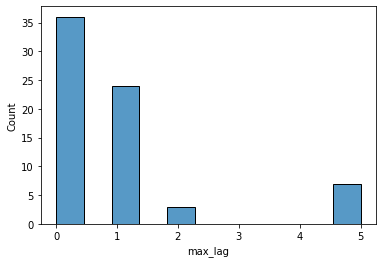

In [36]:
# Distribution of max lag
sns.histplot(data=df_max_lag, x='max_lag')

There seems to be mostly 1 or 2 lags relevant! That is good news!

C:\Users\phili\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\phili\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\phili\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by sett

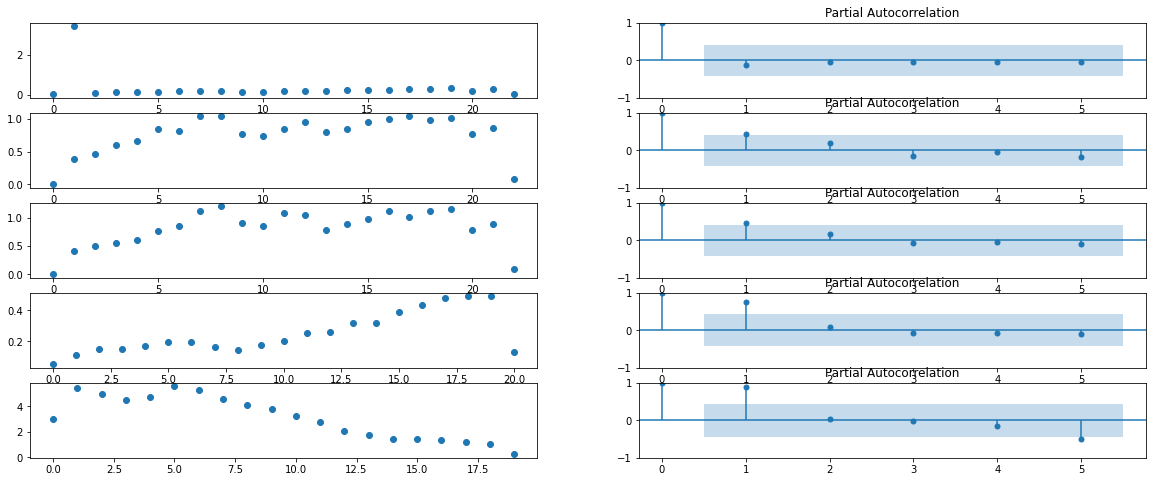

In [38]:
# Inspect where lots of lags are relevant
df_max_lag.sort_values('max_lag', ascending=False)

# Create subplots for: scatter + pacf + other
fig, axs = plt.subplots(5, 2, figsize=(20, 8))

for i in range(5):

    # isin_i = "IE00B14X4S71"
    isin_i = df_max_lag.reset_index().iloc[i,]['index']

    x_ = df_temp_exp_y[df_temp_exp_y.Security_ISIN == isin_i]['Dist_Amount']

    # Plot all scatter and pacf
    axs[i,0].scatter(x=[*range(len(x_))], y=x_)

    plot_pacf(x_, lags=5, alpha=0.05, ax=axs[i,1])

plt.show()

## Setup testing framework

Need framework to quickly assess the quality of a forecast model.

Need to check:
* Backtesting results
* Train vs Test performance
* Out-of-sample performace -> how does the model behave for the next N Quarters. Does it get negative? Does it explode?

Plan:

* So, for each ETF-product, we need to split the data into test/train
* Then, the backtesting will be an in-sample check for the training periods and a first out-of-sample test for the testing periods
* Then, we will let the model run for another N quarters to observe the model behavior in totally unknown periods

Problems:

* Analysis of several time series at once. Usual analysis of time series only perfomred on one group. Need to find approach to estimate for all ETF-products at once!
* Different time horizones -> Need to split data into even buckets?

In [345]:
# Let's start with setting up the data structure

# Ref 1: https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

df_model = df_temp_exp_y.copy()

# df_model.head()

# Normalize values or work with difflogs
# df_model[df_model.Dist_Amount != 0].groupby(['Year']).agg({'count'}) # -> 2021
# df_model_base = df_model[df_model.Year == 2021].rename(columns={'Dist_Amount': 'Dist_Base'}).drop('Year', axis = 1)

# df_model = df_model.join(df_model_base.set_index(['Security_ISIN']), on = 'Security_ISIN')
# df_model['Dist_Amount'] = df_model['Dist_Amount'] / df_model['Dist_Base']
# df_model.drop('Dist_Base', axis=1, inplace=True)

# Replace 0 values with 0.0001
df_model.loc[df_model.Dist_Amount == 0, 'Dist_Amount'] = 0.0001

# Transform to log
df_model['Dist_Amount'] = np.log(df_model['Dist_Amount'])



# Y = Dist_Amount
# X = Lag Levels + Lag Diffs

# Add lagged levels
df_model['Dist_L1'] = df_model.groupby(['Security_ISIN'])['Dist_Amount'].shift()
df_model['Dist_L2'] = df_model.groupby(['Security_ISIN'])['Dist_Amount'].shift(2)
df_model['Dist_L3'] = df_model.groupby(['Security_ISIN'])['Dist_Amount'].shift(3)
df_model['Dist_L4'] = df_model.groupby(['Security_ISIN'])['Dist_Amount'].shift(4)

# Calculate differences
df_model['DDist_L1_L2'] = df_model['Dist_L1'] - df_model['Dist_L2']
df_model['DDist_L1_L3'] = df_model['Dist_L1'] - df_model['Dist_L3']
df_model['DDist_L1_L4'] = df_model['Dist_L1'] - df_model['Dist_L4']

df_model['DDist_L2_L3'] = df_model['Dist_L2'] - df_model['Dist_L3']
df_model['DDist_L2_L4'] = df_model['Dist_L2'] - df_model['Dist_L4']

df_model['DDist_L3_L4'] = df_model['Dist_L2'] - df_model['Dist_L4']

# Drop Infinity - DON'T. Replace 0 values with 0.0001
# df_model.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NA values - obs with not enough lagged data
df_model = df_model.dropna()

# Reset index
df_model.reset_index(drop=True, inplace=True)


## Try different models

Compare different models for their ability to predict distributions

Test:
* Base Case: T = (T-1) -> simple lagged model
* Linear Regression
* Random Forest Regressor
* SARIMA


In general, we might have a problem with a lot of 0s.
Some funds distribute quarterly, some only every second and some only yearly.
And some will change their distributions intervals over time.


Do we need to create a separate model for each distribution interval?
* Quarterly distributions
* Semi-Annual distributions
* Annaul distributions


## Define Train and test data sets

For now, define a single split. Later on, move this split year to increase model stability

In [346]:
train = df_model[df_model.Year < 2018].drop(['Security_ISIN', 'Year'], axis = 1)
test = df_model[df_model.Year >= 2018].drop(['Security_ISIN', 'Year'], axis = 1)

X_train = train.drop(['Dist_Amount'], axis = 1)
X_test = test.drop(['Dist_Amount'], axis = 1)

Y_train = train['Dist_Amount']
Y_test = test['Dist_Amount']

### Baseline

### Random Forest

In [347]:
# First, simple model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

model_rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
model_rf.fit(X_train, Y_train)

p = model_rf.predict(X_test)

error = mean_squared_error(Y_test, p)
error


2.9430334904930637

In [348]:
train = df_model.drop(['Security_ISIN', 'Year'], axis = 1)
test = df_model.drop(['Security_ISIN', 'Year'], axis = 1)

X_train = train.drop(['Dist_Amount'], axis = 1)
X_test = test.drop(['Dist_Amount'], axis = 1)

Y_train = train['Dist_Amount']
Y_test = test['Dist_Amount']

In [349]:
# Custom gridsearh cv for hyperparamter tuning

# Split data either by Security_ISIN or by Year

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

mean_squared_error_score = make_scorer(mean_squared_error)
mean_absolute_percentage_error_score = make_scorer(mean_absolute_percentage_error)

CViterator = []
for i in range(2016, 2020):
    trainIndices = df_model[ df_model.Year < i ].index.values.astype(int)
    testIndices =  df_model[ df_model.Year >= i ].index.values.astype(int)
    CViterator.append( (trainIndices, testIndices) )

param_search = { 
    'n_estimators': [20, 50, 100], #, 500, 1000
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(10,20)]
}

gsearch = GridSearchCV(estimator=model_rf, cv=CViterator, param_grid=param_search, scoring=mean_absolute_percentage_error_score)
gsearch.fit(X_train, Y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_



In [320]:
best_score

1.0204427086985681

In [350]:
best_model

RandomForestRegressor(max_depth=19, max_features='log2', n_estimators=20,
                      n_jobs=-1, random_state=0)

## Compare forecast over different time horizons

Model trained to work for 1 year prediction. Test up to 5 / 10 year predictions!

In [351]:
# Visually inspect forecast quality!!!
df_pred = df_model.copy()

# Feature columns
feature_cols = ["Dist_L1", "Dist_L2", "Dist_L3", "Dist_L4", "DDist_L1_L2", "DDist_L1_L3", "DDist_L1_L4", "DDist_L2_L3", "DDist_L2_L4", "DDist_L3_L4"]

df_pred['Year_Base'] = df_pred['Year']

# isin_i = "IE00B296QM64"
for year_base_i in range(2016, 2022):
# year_base_i = 2016

    # Predict starting in year 2018 for n years
    df_pred_i = df_pred[df_pred.Year_Base == year_base_i].copy()

    for year_pred_i in range(year_base_i + 1, year_base_i + 5):

        # Extract previous year data
        df_pred_i_add = df_pred_i.loc[df_pred_i.Year == year_pred_i - 1].copy()

        # Predict for Year 2019
        pred_i = best_model.predict(df_pred_i_add[feature_cols])

        # calculate df for year of prediction
        # df_pred_i_add = df_pred_i.copy()
        df_pred_i_add['Year'] = year_pred_i

        # Copy level values
        df_pred_i_add['Dist_L4'] = df_pred_i_add['Dist_L3']
        df_pred_i_add['Dist_L3'] = df_pred_i_add['Dist_L2']
        df_pred_i_add['Dist_L2'] = df_pred_i_add['Dist_L1']
        df_pred_i_add['Dist_L1'] = df_pred_i_add['Dist_Amount']

        # Recalculate all differences
        # TODO: Make a function.
        df_pred_i_add['DDist_L1_L2'] = df_pred_i_add['Dist_L1'] - df_pred_i_add['Dist_L2']
        df_pred_i_add['DDist_L1_L3'] = df_pred_i_add['Dist_L1'] - df_pred_i_add['Dist_L3']
        df_pred_i_add['DDist_L1_L4'] = df_pred_i_add['Dist_L1'] - df_pred_i_add['Dist_L4']

        df_pred_i_add['DDist_L2_L3'] = df_pred_i_add['Dist_L2'] - df_pred_i_add['Dist_L3']
        df_pred_i_add['DDist_L2_L4'] = df_pred_i_add['Dist_L2'] - df_pred_i_add['Dist_L4']

        df_pred_i_add['DDist_L3_L4'] = df_pred_i_add['Dist_L2'] - df_pred_i_add['Dist_L4']

        # Enter current prediction
        df_pred_i_add['Dist_Amount'] = pred_i

        df_pred_i = df_pred_i.append(df_pred_i_add)

    df_pred = df_pred.append(df_pred_i[df_pred_i.Year != df_pred_i.Year_Base])


In [352]:
# Calculate predicted and actual distributions over 1, 2, 3, 4, 5 years
# Find largest differences !!!
# Also look at different starting dates

df_pred_check = df_pred.copy()

df_pred_check['N_Years_Ahead'] = df_pred_check['Year'] - df_pred_check['Year_Base']

# Filter to predictions only
df_pred_check = df_pred_check[df_pred_check.N_Years_Ahead != 0]

# Select relevant columns
df_pred_check = df_pred_check[['Security_ISIN', 'Year', 'N_Years_Ahead', 'Dist_Amount']].rename(columns={'Dist_Amount': 'Pred_Amount'})

# Add actual distributions
df_pred_check = df_pred_check.join(df_model[['Security_ISIN', 'Year', 'Dist_Amount']].set_index(['Security_ISIN', 'Year']), on=['Security_ISIN', 'Year'], how='left')

# Drop NAs - meaning, there is no information available!
df_pred_check.dropna(inplace=True)

# Calculate absolute error
df_pred_check['Abs_Error'] = abs(df_pred_check['Pred_Amount'] - df_pred_check['Dist_Amount'])
df_pred_check['Abs_Perc_Error'] = abs(df_pred_check['Pred_Amount'] - df_pred_check['Dist_Amount']) / df_pred_check['Pred_Amount']

df_pred_check.head()

# Over all securities, calculate max, min, avg, median of absolute error
df_pred_check.groupby(['N_Years_Ahead']).agg({'Abs_Error': 'mean', 'Abs_Perc_Error': 'mean'})
# Error increase with the number of forecasted periods -> That's as expected :)




,Abs_Error,Abs_Perc_Error
N_Years_Ahead,,
1,0.544752,8.261633
2,0.599120,10.141838
3,0.803851,-0.847142
4,0.985902,-7.406978


In [353]:
# Determine ETF products with largest errors
df_err_by_isin = df_pred_check.groupby(['Security_ISIN']).agg({'Abs_Perc_Error': 'mean'}).reset_index().sort_values('Abs_Perc_Error', ascending=False)

# print(df_err_by_isin.head())

# Select top 5 and bottom 5
isin_list = df_err_by_isin[:5]['Security_ISIN']
isin_list = isin_list.append(df_err_by_isin['Security_ISIN'].tail(5))

isin_list

28    IE00B14X4T88
10    IE00B02KXL92
61    IE00B3F81R35
15    IE00B0M62Y33
23    IE00B0M63953
21    IE00B0M63623
11    IE00B02KXM00
2     IE0008471009
18    IE00B0M63284
35    IE00B1FZS806
Name: Security_ISIN, dtype: object

In [354]:

# Reverse log transform
df_pred['Dist_Amount'] = np.exp(df_pred['Dist_Amount'])

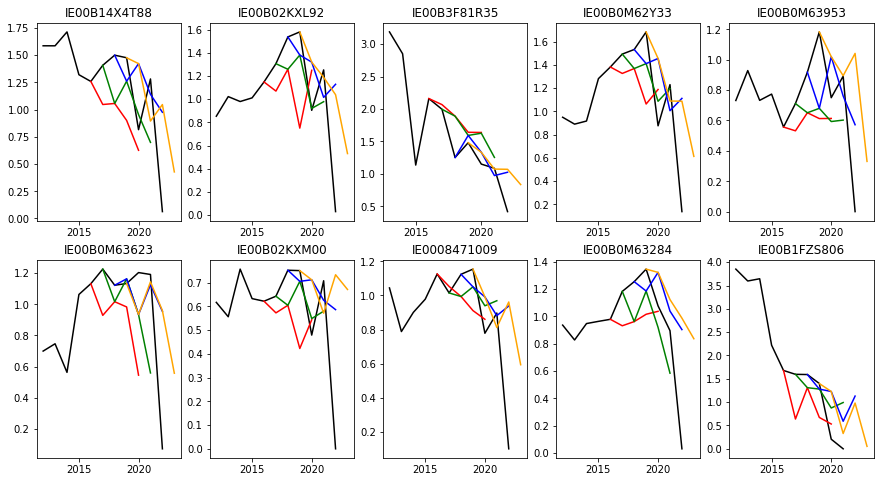

In [355]:
# Visualize with line plot

# TODO: Sort by goodness of fit !!!!!
# TODO: SELECT Top / Mid / Bottom 5 for blog post!!

import matplotlib.pyplot as plt
import math

# df_plot = df_pred.copy()

# isin_unique = df_pred.Security_ISIN.unique()

# Determine first year_base for predictions
min_year_base = df_pred[df_pred.Year != df_pred.Year_Base].Year_Base.min()

# fig = plt.figure(figsize=(10,8))

# Loop over first 25 ETF products
fig, ax = plt.subplots(2, 5, figsize=(15, 8))

colors = ['red', 'green', 'blue', 'orange', 'purple']

# Create tuples for plot locations
ax_loc = []
for r in range(2):
    for c in range(5):
        ax_loc.append((r, c))

for i_, isin_i in enumerate(isin_list): #[:25]):

    # isin_i = "IE00B296QM64"
    df_plot = df_pred[df_pred.Security_ISIN == isin_i].copy()

    df_plot_base = df_plot[df_plot.Year == df_plot.Year_Base].copy()

    # Reduce time horizon
    df_plot_base = df_plot_base[df_plot_base.Year >= (min_year_base - 4)]

    # ax_x = i_ % 5
    # ax_y = math.trunc(i_ / 3)
    ax_x, ax_y = ax_loc[i_]

    ax[ax_x,ax_y].plot(df_plot_base['Year'], df_plot_base['Dist_Amount'], color='black')

    for i__, year_base_i in enumerate(range(min_year_base, min_year_base + 4)):
        df_plot_i = df_plot[df_plot.Year_Base == year_base_i]
        ax[ax_x,ax_y].plot(df_plot_i['Year'], df_plot_i['Dist_Amount'], color=colors[i__])

    ax[ax_x,ax_y].set_title(isin_i)

plt.show()


# TODO: Absolute errors and values do not work. Need to normalize data for the model?!
# TODO: It seems like intense up/downward swings are not realized by the model. Extend features by rate of changes? First, second degree?


## Out of sample for all products

Predict for all products the next 5 years of distributions starting from 2021

-> SELECT 25 products at maxium!! 
110 products is too much! not readable on website!

In [373]:
# df_plot = df_plot.join(df_sort.set_index('Security_ISIN'), on = 'Security_ISIN', how = 'left').sort_values(['Cor', 'Year'], ascending = [False, True])
isin_list = df_sort[df_sort.Security_ISIN.isin(df_pred.Security_ISIN)].sort_values(['Cor'], ascending=False)[::3]['Security_ISIN'][:25]
len(isin_list)

25

In [383]:
# TODO

import matplotlib.pyplot as plt
import math

# df_plot = df_pred.copy()

# isin_unique = df_pred.Security_ISIN.unique()

# Determine first year_base for predictions
min_year_base = df_pred[df_pred.Year != df_pred.Year_Base].Year_Base.min()

# fig = plt.figure(figsize=(10,8))

# Loop over first 25 ETF products
fig, ax = plt.subplots(5, 5, figsize=(15, 15), sharex=True)
fig.tight_layout(h_pad=2)

colors = ['red', 'green', 'blue', 'orange', 'purple']

# Create tuples for plot locations
ax_loc = []
for r in range(5):
    for c in range(5):
        ax_loc.append((r, c))

for i_, isin_i in enumerate(isin_list): #[:25]):

    # isin_i = "IE00B296QM64"
    df_plot = df_pred[df_pred.Security_ISIN == isin_i].copy()

    df_plot_base = df_plot[df_plot.Year == df_plot.Year_Base].copy()

    # Reduce time horizon
    df_plot_base = df_plot_base[df_plot_base.Year >= (min_year_base - 4)]

    # Get coordinates of current subplot
    ax_x, ax_y = ax_loc[i_]

    ax[ax_x,ax_y].plot(df_plot_base['Year'], df_plot_base['Dist_Amount'], color='black')

    for i__, year_base_i in enumerate(range(2021, 2022)):
        df_plot_i = df_plot[df_plot.Year_Base == year_base_i]
        ax[ax_x,ax_y].plot(df_plot_i['Year'], df_plot_i['Dist_Amount'], color=colors[i__])

    ax[ax_x,ax_y].set_title(isin_i)

fig.suptitle('Forecast of Distributions: 2022 - 2025')
plt.subplots_adjust(top=0.925)

plt.show()
